# Yelp review 

We will use the [Yelp Review Data Set from Kaggle](https://www.kaggle.com/c/yelp-recsys-2013).


In [1]:
import nltk 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline

### Read data

In [3]:
url = 'https://raw.githubusercontent.com/justmarkham/DAT8/master/data/yelp.csv'
yelp = pd.read_csv(url)
yelp.head(2)

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0


In [4]:
yelp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
business_id    10000 non-null object
date           10000 non-null object
review_id      10000 non-null object
stars          10000 non-null int64
text           10000 non-null object
type           10000 non-null object
user_id        10000 non-null object
cool           10000 non-null int64
useful         10000 non-null int64
funny          10000 non-null int64
dtypes: int64(4), object(6)
memory usage: 781.3+ KB


In [5]:
yelp.describe()

,stars,cool,useful,funny
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,3.777500,0.876800,1.409300,0.701300
std,1.214636,2.067861,2.336647,1.907942
min,1.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000,0.000000
50%,4.000000,0.000000,1.000000,0.000000
75%,5.000000,1.000000,2.000000,1.000000
max,5.000000,77.000000,76.000000,57.000000


### Explore data

In [6]:
yelp['length'] = yelp.text.apply(len)

Use FacetGrid from the seaborn library to create a grid of 5 histograms of text

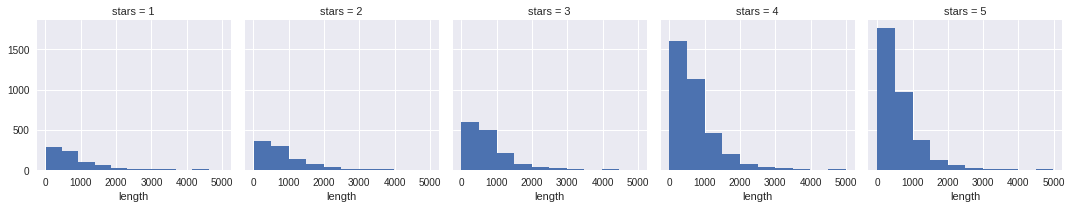

In [7]:
g = sns.FacetGrid(yelp,col='stars')
g.map(plt.hist,'length')

Create a boxplot of text length for each star category.

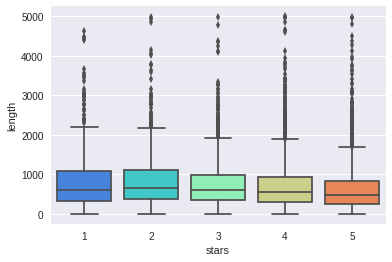

In [8]:
sns.boxplot(x='stars',y='length',data=yelp,palette='rainbow')

Create a countplot of the number of occurrences for each type of star rating.

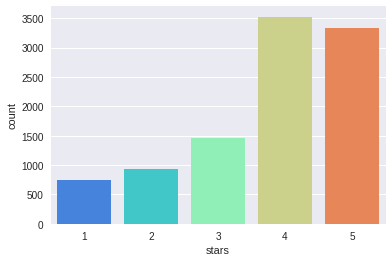

In [9]:
sns.countplot(x='stars',data=yelp,palette='rainbow')

In [10]:
## show value counts 
yelp.stars.value_counts()

4    3526
5    3337
3    1461
2     927
1     749
Name: stars, dtype: int64

Use groupby to get the mean values of the numerical columns

In [11]:
stars = yelp.groupby('stars').mean()
stars

,cool,useful,funny,length
stars,,,,
1,0.576769,1.604806,1.056075,826.515354
2,0.719525,1.563107,0.875944,842.256742
3,0.788501,1.306639,0.694730,758.498289
4,0.954623,1.395916,0.670448,712.923142
5,0.944261,1.381780,0.608631,624.999101


Use the corr() method on that groupby dataframe to produce this dataframe:

In [12]:
## corrolations of all the variables 
stars.corr()

,cool,useful,funny,length
cool,1.000000,-0.743329,-0.944939,-0.857664
useful,-0.743329,1.000000,0.894506,0.699881
funny,-0.944939,0.894506,1.000000,0.843461
length,-0.857664,0.699881,0.843461,1.000000


Then use seaborn to create a heatmap based off that .corr() dataframe:

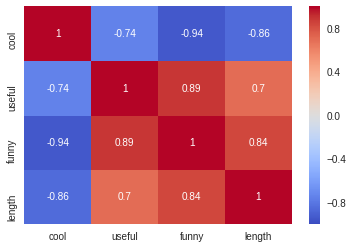

In [13]:
sns.heatmap(stars.corr(),cmap='coolwarm',annot=True)

## NLP Classification
Create a dataframe called yelp_class that contains the columns of yelp dataframe but for only the 1 or 5 star reviews.

In [14]:
yelp_class = yelp[(yelp.stars==1) | (yelp.stars==5)]

Create two objects X and y, and transform X to sparse matrix 

In [15]:
X = yelp_class.text
y = yelp_class.stars

from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
X = cv.fit_transform(X)   ## fit and transform X 

In [16]:
## train text split 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3,random_state=101)

#### Training a Model


In [17]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()            ## use naive beyes
nb.fit(X_train,y_train)         ## fit the data
predictions = nb.predict(X_test)## predict on test data 
predictions                     ## print result

array([5, 1, 5, ..., 5, 5, 5])

#### Evaluation

In [18]:
from sklearn.metrics import confusion_matrix,classification_report
print(confusion_matrix(y_test,predictions))
print('\n')
print(classification_report(y_test,predictions))

[[159  69]
 [ 22 976]]


             precision    recall  f1-score   support

          1       0.88      0.70      0.78       228
          5       0.93      0.98      0.96       998

avg / total       0.92      0.93      0.92      1226



### Using Tfidf and use pipeline


In [20]:
from sklearn.feature_extraction.text import  TfidfTransformer
from sklearn.pipeline import Pipeline

create pipeline

In [21]:
pipeline = Pipeline([
    ('bow', CountVectorizer()),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

Now, re-split the data and run the pipeline

In [22]:
X = yelp['text']
y = yelp['stars']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3,random_state=101)

pipeline.fit(X_train,y_train)
predictions = pipeline.predict(X_test)
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))

[[  0   0   0 187  33]
 [  0   0   0 266   7]
 [  0   0   1 422  20]
 [  0   0   0 974  90]
 [  0   0   0 708 292]]
             precision    recall  f1-score   support

          1       0.00      0.00      0.00       220
          2       0.00      0.00      0.00       273
          3       1.00      0.00      0.00       443
          4       0.38      0.92      0.54      1064
          5       0.66      0.29      0.40      1000

avg / total       0.50      0.42      0.33      3000



/home/chengyu/anaconda3/envs/my_root/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### ok, interesting, tfidf actually mde things a lot worse, maybe it is because low star review has too little words 